In [21]:
from glob import glob

import anndata
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

In [2]:
adatas = []
for fname in tqdm(glob('GSE214695_RAW/*_matrix.mtx.gz')):
    adata = anndata.read_mtx(fname).T
    
    obs = (
        pd.read_csv(
            fname.replace('_matrix.mtx.gz', '_barcodes.tsv.gz'),
            names = ['barcode']
        )
        .set_index('barcode')
    )
    
    var = (
        pd.read_csv(
            fname.replace('_matrix.mtx.gz', '_features.tsv.gz'),
            sep = '\t',
            names = ['gene_id', 'gene_name', 'feature_type']
        )
        .set_index('gene_name')
    )
    
    adata.obs = obs
    adata.var = var

    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    
    adata.obs['sample_name'] = fname.replace('_matrix.mtx.gz', '')
    
    adatas += [adata]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:51<00:00, 26.20s/it]


In [3]:
alladata = anndata.concat(adatas, index_unique = '-', merge = 'same')

In [4]:
alladata

AnnData object with n_obs × n_vars = 116250240 × 33538
    obs: 'sample_name'
    var: 'gene_id', 'feature_type'

In [15]:
alladata.obs['total_counts'] = alladata.X.sum(1)

In [27]:
tmp = alladata.obs.query('total_counts > 0').sort_values('total_counts', ascending = False)

In [28]:
tmp['rank'] = np.arange( tmp.shape[0])

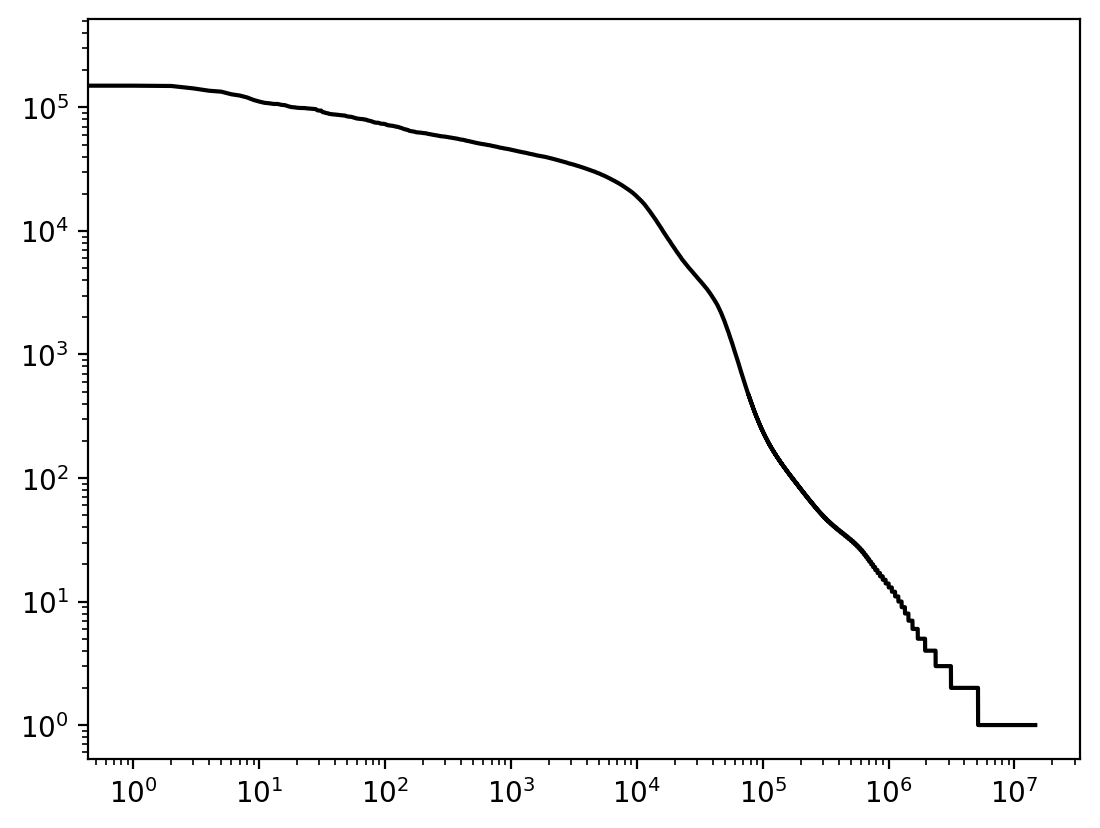

In [29]:
plt.plot(tmp['rank'], tmp['total_counts'], color = 'black')
plt.loglog();

In [35]:
grps_ = []
for n_, grp_ in tmp.groupby('sample_name'):
    grp_['rank'] = np.arange(grp_.shape[0])
    grps_ += [grp_]

In [37]:
tmp2 = pd.concat(grps_)

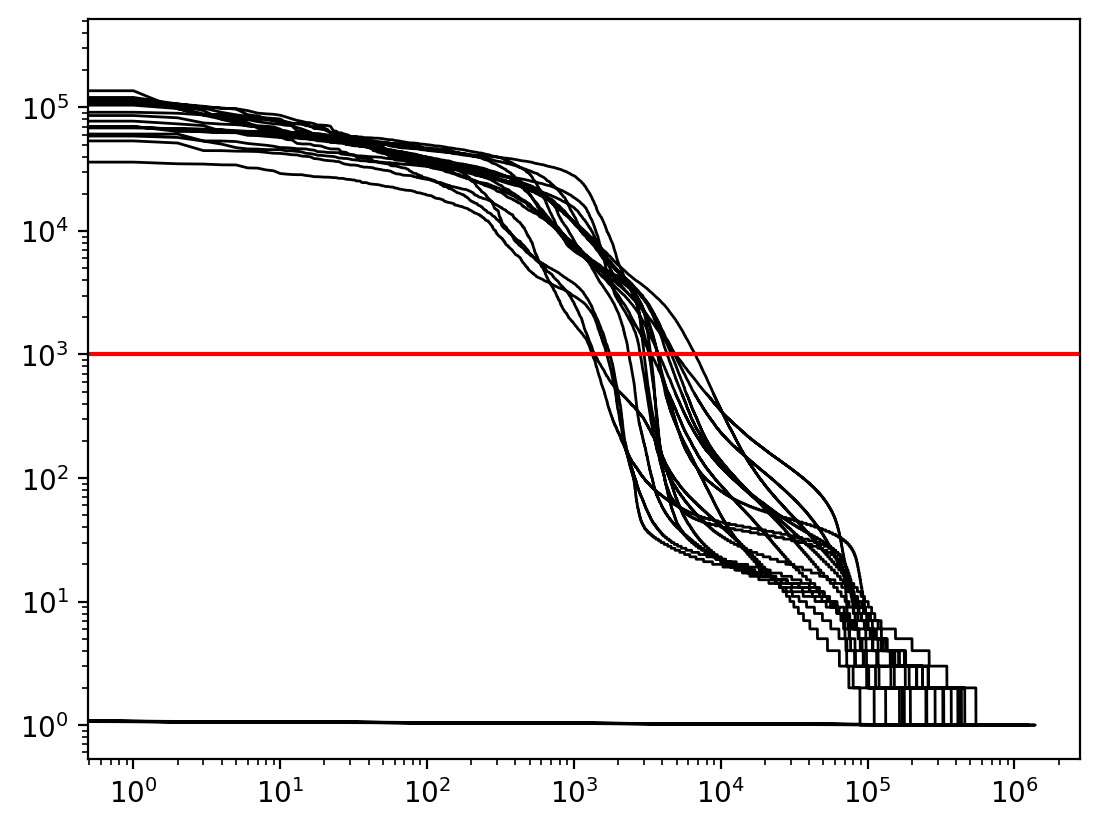

In [42]:
plt.plot(tmp2['rank'], tmp2['total_counts'], color = 'black', lw = 1)
plt.axhline(y = 1e3, color = 'red')
plt.loglog();

In [43]:
tmp.query('total_counts >= 1e3').shape

(60952, 3)

In [45]:
falladata = alladata[alladata.obs.query('total_counts >= 1e3').index].copy()

In [46]:
falladata

AnnData object with n_obs × n_vars = 60952 × 33538
    obs: 'sample_name', 'total_counts'
    var: 'gene_id', 'feature_type'

In [47]:
falladata.var

,gene_id,feature_type
gene_name,,
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression


In [48]:
falladata.obs

,sample_name,total_counts
barcode,,
AAACCTGAGGTCGGAT-1-0,GSE214695_RAW/GSM6614348_HC-1,13513.0
AAACCTGCAAGTCTGT-1-0,GSE214695_RAW/GSM6614348_HC-1,2057.0
AAACCTGGTCGTCTTC-1-0,GSE214695_RAW/GSM6614348_HC-1,2021.0
AAACCTGGTTATGCGT-1-0,GSE214695_RAW/GSM6614348_HC-1,2729.0
AAACCTGTCGGCATCG-1-0,GSE214695_RAW/GSM6614348_HC-1,3226.0
...,...,...
TTTGTTGGTAATGTGA-1-17,GSE214695_RAW/GSM6614365_CD-6,3663.0
TTTGTTGGTCTAGGTT-1-17,GSE214695_RAW/GSM6614365_CD-6,1037.0
TTTGTTGGTGGCTACC-1-17,GSE214695_RAW/GSM6614365_CD-6,9117.0


In [49]:
falladata.X

<60952x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 74053644 stored elements in Compressed Sparse Row format>

In [50]:
falladata.X.data[:100]

array([ 1.,  1.,  2.,  1.,  2.,  1.,  7.,  1.,  1.,  2.,  1.,  1.,  1.,
        2.,  1.,  1.,  3., 27.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  2.,
        1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  3.,
        4.,  1.,  1., 26.,  1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,
        4., 16.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  8.,  1.,
        2.,  1.,  1.,  1.,  3.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  9.,
        2.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  3., 43.,  1.,  1.,  7.,
        4.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [52]:
falladata.write('GSE214695.h5ad')

In [53]:
ls -lh

total 573M
-rwxrwxrwx 1 vale vale 202K Aug 14 21:30 '230814 Read data.ipynb'*
-rwxrwxrwx 1 vale vale 573M Aug 14 21:31  GSE214695.h5ad*
drwxrwxrwx 1 vale vale 4.0K Aug 14 20:53  GSE214695_RAW/
